<a href="https://colab.research.google.com/github/clemBrest/DS2Project/blob/main/tipJetAnalyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/clemBrest/DS2Project/HEAD)


---



In [ ]:
!pip install zarr
!pip install gcsfs
!pip uninstall -y shapely
!pip install shapely==1.8.5 --no-binary shapely
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.7 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=5e8dd0edc7eb2b07a6956320a27706c4b2f57f65486f250ebf4cac6cc190a859
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree
Found existing installation: shapely 2.0.2
Uninstalling shapely-2.0.2:
  Successfully uninstalled shapely-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=Shapely-1.8.5-cp310-cp310-linux_x86_64.whl size=832070 sha256=e3c3087c4b02d7aab390f9642bf0d78f02f

In [69]:

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr

# gcsfs to read data from online storage
import gcsfs

# sklearn for the EOF decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# mit to find consecutive numbers in a given list
import more_itertools as mit

# cartopy to plot geographical maps
import cartopy.crs as ccrs

# pyproj to compute clean distance between longitudes and latitudes
from pyproj import Geod
g = Geod(ellps='WGS84')

lon_a, lat_a = 360+np.linspace(-47, -40, 20), np.linspace(60, 62, 20)
lon_b, lat_b = 360+np.linspace(-45, -40, 20), np.linspace(57, 62, 20)
lon_c, lat_c = 360+np.linspace(-40, -40, 20), np.linspace(56.5, 62, 20)

def consecutiveGroupes(indices):
    consec = []
    for group in mit.consecutive_groups(indices):
        consec.append(list(group))

    return np.array(consec, dtype='object')

class TipJet():
    def __init__(self, activity_id='ScenarioMIP', table_id='day', experiment_id= 'historical', source_id='IPSL-CM6A-LR',member_id = 'r2i1p1f1'):

        self.activity_id = activity_id
        self.table_id = table_id
        self.experiment_id = experiment_id
        self.source_id = source_id
        self.member_id = member_id

        self.df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

        self.uas()
        self.sfcWind()

        self.tas()
        self.psl()



    def uas(self):
        self.df_uas = self.df.query(f"activity_id=='{self.activity_id}' & table_id=='{self.table_id}' & experiment_id=='{self.experiment_id}' & variable_id=='uas' & source_id=='{self.source_id}' & member_id=='{self.member_id}'")
        gcs = gcsfs.GCSFileSystem(token='anon')
        zstore = self.df_uas.zstore.values[-1]
        mapper = gcs.get_mapper(zstore)
        ds_uas = xr.open_zarr(mapper, consolidated=True,decode_times=False).uas

        self.ds_uas = ds_uas



    def sfcWind(self):
        self.df_sfcWind = self.df.query(f"activity_id=='{self.activity_id}' & table_id=='{self.table_id}' & experiment_id=='{self.experiment_id}' & variable_id=='sfcWind' & source_id=='{self.source_id}' & member_id=='{self.member_id}'")

        gcs = gcsfs.GCSFileSystem(token='anon')
        zstore = self.df_sfcWind.zstore.values[-1]
        mapper = gcs.get_mapper(zstore)
        ds_windmag = xr.open_zarr(mapper, consolidated=True,decode_times=False).sfcWind

        self.ds_windmag = ds_windmag
        ds_uas = self.ds_uas

        # We select the area and the data since 1950
        wind_mag_area= ds_windmag.where((ds_windmag.lat>57)&(ds_windmag.lat<61)&(ds_windmag.lon>360-46)&(ds_windmag.lon<360-33), drop=True)
        # .isel(time=np.arange(ds_windmag.time.size-ds_uas.time.size, ds_windmag.time.size))

        # we convert the xr.Dataarray to np.array to make easy the processing
        self.magnitude_np = wind_mag_area.values

        # Linear interpolation along x
        magnitude_at_u = 0.5*(self.magnitude_np[:,:,:-1]+self.magnitude_np[:,:,1:])

        wind_mag_area_ravelled = np.array([magnitude_at_u[i].ravel() for i in range(len(magnitude_at_u))]) # This for loop look at the maximum for each time step

        argmax_wind = np.argmax(wind_mag_area_ravelled, axis=1)

        # We do the same to extract uas at this maximum
        self.wind_area_u = ds_uas.where((ds_uas.lat>57)&(ds_uas.lat<61)&(ds_uas.lon>360-45)&(ds_uas.lon<360-34), drop=True)
        u_np = self.wind_area_u.values
        self.u_at_max = np.array([u_np[i].ravel()[argmax_wind[i]] for i in range(len(u_np))])



    def tas(self):
        self.df_tas = self.df.query(f"activity_id=='{self.activity_id}' & table_id=='{self.table_id}' & experiment_id=='{self.experiment_id}' & variable_id=='tas' & source_id=='{self.source_id}' & member_id=='{self.member_id}'")
        gcs = gcsfs.GCSFileSystem(token='anon')
        zstore = self.df_tas.zstore.values[-1]
        mapper = gcs.get_mapper(zstore)
        ds_temp = xr.open_zarr(mapper, consolidated=True,decode_times=False).tas

        self.temp = ds_temp


        temp_area = ds_temp.where((ds_temp.lat>57)&(ds_temp.lat<61)&(ds_temp.lon>360-46)&(ds_temp.lon<360-33), drop=True)
        # .isel(time=np.arange(ds_temp.time.size-ds_uas.time.size, ds_temp.time.size))

        wind_mag_area_ravelled = np.array([self.magnitude_np[i].ravel() for i in range(len(self.magnitude_np))])

        argmax_wind = np.argmax(wind_mag_area_ravelled, axis=1)

        # Extract the temperature at these maximums

        t_np = temp_area.values

        self.t_at_max = np.array([t_np[i].ravel()[argmax_wind[i]] for i in range(len(t_np))])-273.15 # Here we can remove -273.15 to convert the data into celsius degree but it is not mandatory


    def psl(self):
        self.df_psl = self.df.query(f"activity_id=='{self.activity_id}' & table_id=='{self.table_id}' & experiment_id=='{self.experiment_id}' & variable_id=='psl' & source_id=='{self.source_id}' & member_id=='{self.member_id}'")
        gcs = gcsfs.GCSFileSystem(token='anon')
        zstore = self.df_psl.zstore.values[-1]
        mapper = gcs.get_mapper(zstore)
        ds_slp = xr.open_zarr(mapper, consolidated=True,decode_times=False).psl

        self.slp = ds_slp


                # select data after 1950
        ds_slp = ds_slp.isel(time=np.arange(ds_slp.time.size-self.ds_uas.time.size, ds_slp.time.size))

        nearest_a_start = ds_slp.sel(lon=lon_a[0], lat=lat_a[0], method='nearest')
        nearest_a_end = ds_slp.sel(lon=lon_a[-1], lat=lat_a[-1], method='nearest')
        nearest_b_start = ds_slp.sel(lon=lon_b[0], lat=lat_b[0], method='nearest')
        nearest_b_end = ds_slp.sel(lon=lon_b[-1], lat=lat_b[-1], method='nearest')
        nearest_c_start = ds_slp.sel(lon=lon_c[0], lat=lat_c[0], method='nearest')
        nearest_c_end = ds_slp.sel(lon=lon_c[-1], lat=lat_c[-1], method='nearest')

        self.grad_a = (nearest_a_start - nearest_a_end) / g.inv(nearest_a_start.lon.values, nearest_a_start.lat.values, nearest_a_end.lon.values, nearest_a_end.lat.values)[2]/1000
        self.grad_b = (nearest_b_start - nearest_b_end) / g.inv(nearest_b_start.lon.values, nearest_b_start.lat.values, nearest_b_end.lon.values, nearest_b_end.lat.values)[2]/1000
        self.grad_c = (nearest_c_start - nearest_c_end) / g.inv(nearest_c_start.lon.values, nearest_c_start.lat.values, nearest_c_end.lon.values, nearest_c_end.lat.values)[2]/1000


    def EOF(self):
        # N, M = len(self.wind_area_u.time.values), 5
        # X = np.zeros((N, M))

        # X[:, 0] = self.u_at_max
        # X[:, 1] = self.t_at_max
        # X[:, 2] = self.grad_a
        # X[:, 3] = self.grad_b
        # X[:, 4] = self.grad_c

        N, M = len(self.wind_area_u.time.values), 5
        X = np.zeros((N, M))

        scaler = StandardScaler()
        scaler.fit(self.u_at_max.reshape(-1, 1))
        X[:, 0] = scaler.transform(self.u_at_max.reshape(-1, 1)).flatten()
        scaler = StandardScaler()
        scaler.fit(self.t_at_max.reshape(-1, 1))
        X[:, 1] = scaler.transform(self.t_at_max.reshape(-1, 1)).flatten()
        scaler = StandardScaler()
        scaler.fit(self.grad_a.values.reshape(-1, 1))
        X[:, 2] = scaler.transform(self.grad_a.values.reshape(-1, 1)).flatten()
        scaler = StandardScaler()
        scaler.fit(self.grad_b.values.reshape(-1, 1))
        X[:, 3] = scaler.transform(self.grad_a.values.reshape(-1, 1)).flatten()
        scaler = StandardScaler()
        scaler.fit(self.grad_c.values.reshape(-1, 1))
        X[:, 4] = scaler.transform(self.grad_c.values.reshape(-1, 1)).flatten()

        pca = PCA(n_components=5)
        pca.fit(X)

        self.Xpca = pca.transform(X)
        self.components = pca.components_

        comp = 0

        self.EOF_wind_intensity =  pca.components_[comp, 0]*self.Xpca[:, comp] + pca.mean_[0]

        plt.plot(self.EOF_wind_intensity[:1000])
        plt.show()


        return self.EOF_wind_intensity

    def events(self):
        self.event = consecutiveGroupes(np.where(self.EOF_wind_intensity>np.percentile(self.EOF_wind_intensity, 95))[0])
        return self.event

    def windmag(self):
        self.ds_windmag_compositeTJ = self.ds_windmag.isel(time=np.arange(self.ds_windmag.time.size-self.ds_uas.time.size, self.ds_windmag.time.size)).isel(time=np.where(self.EOF_wind_intensity>np.percentile(self.EOF_wind_intensity, 95))[0]).mean('time')

        return self.ds_windmag_compositeTJ

    def histo_vent(self):
        flat_events = [item for sublist in self.event for item in sublist]
        plt.hist(self.u_at_max[flat_events], bins=20, color='blue', edgecolor='black')

        # Add labels and title
        plt.title('Histogram of max speed during events')
        plt.xlabel('Values')
        plt.ylabel('Frequency')

        # Show the plot
        plt.show()
        return self.u_at_max[flat_events]






In [70]:
class Ensemble:
  def __init__(self,list_of_member, scenario):
    self.list_of_member = list_of_member
    self.scenario = scenario

    # self.list_of_TJ = []
    self.dic_TJ = {}

    for member in self.list_of_member:
      # self.list_of_TJ.append(TipJet(activity_id='ScenarioMIP', table_id='day', experiment_id= self.scenario, source_id='IPSL-CM6A-LR',member_id = member))
      self.dic_TJ[member] = TipJet(activity_id='ScenarioMIP', table_id='day', experiment_id= self.scenario, source_id='IPSL-CM6A-LR',member_id = member)

      print(member)

  def EOF(self):
    # self.list_EOF = []
    self.dic_EOF = {}
    # for TJ in self.dic_TJ:
    for member, TJ in self.dic_TJ.items():
      # self.list_EOF.append(TJ.EOF())
      self.dic_EOF[member] = TJ.EOF()
    return self.dic_EOF




In [71]:
EnsTJ126 = Ensemble(list_of_member = ['r2i1p1f1','r3i1p1f1','r4i1p1f1'], scenario='ssp126' )

r2i1p1f1
r3i1p1f1
r4i1p1f1


In [72]:
EnsTJ585 = Ensemble(list_of_member = ['r2i1p1f1','r3i1p1f1','r4i1p1f1'], scenario='ssp585' )

r2i1p1f1
r3i1p1f1
r4i1p1f1


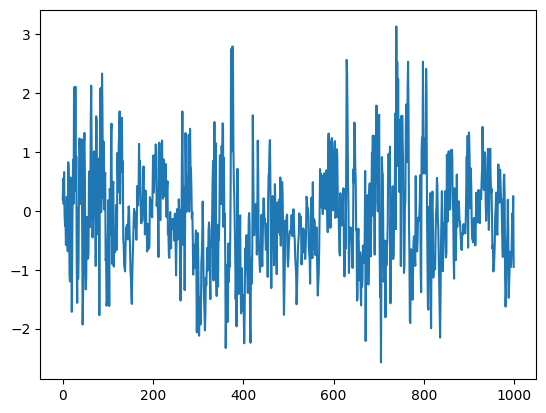

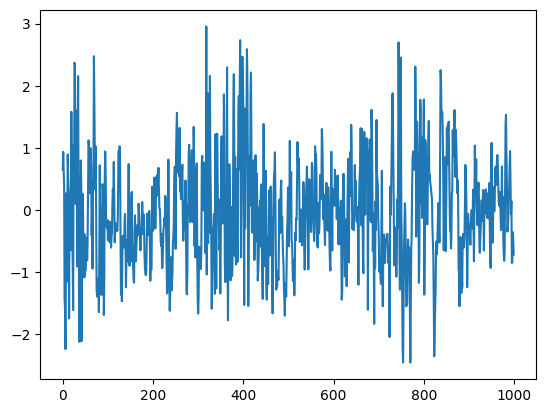

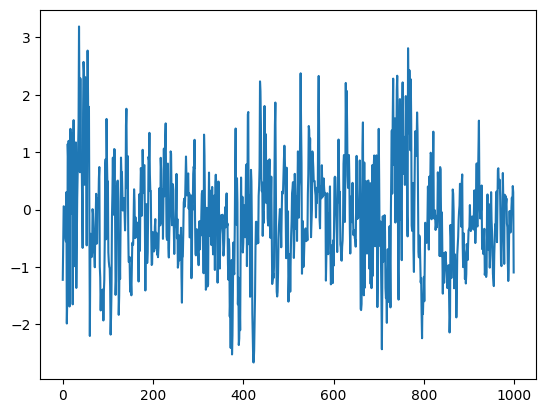

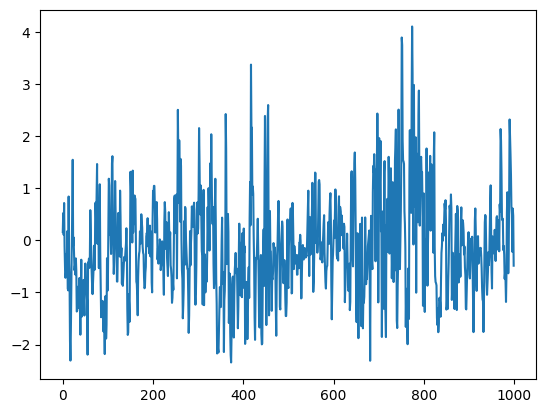

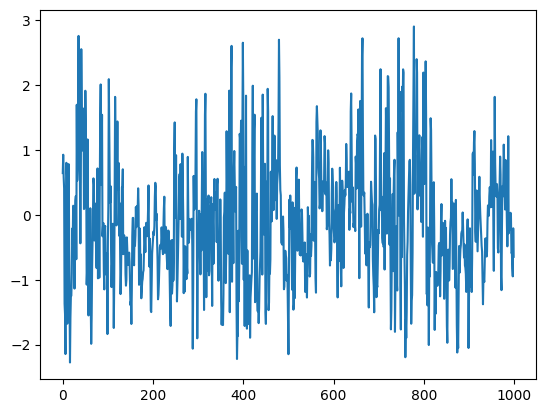

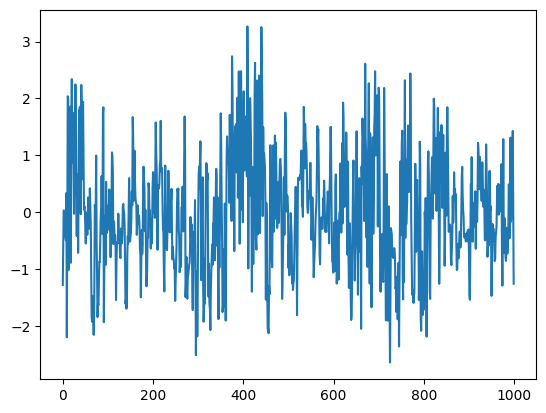

{'r2i1p1f1': array([ 0.15999183,  0.52263048,  0.10688766, ..., -0.08290228,
         0.21331222,  0.38599507]),
 'r3i1p1f1': array([0.64358524, 0.92631603, 0.57913033, ..., 2.31793897, 1.40369282,
        1.10442965]),
 'r4i1p1f1': array([-1.27926128, -0.53547185,  0.03079583, ..., -0.45769714,
         1.70004421,  2.19079021])}

In [73]:
EnsTJ126.EOF()
EnsTJ585.EOF()



In [85]:
EnsTJ585.dic_TJ['r2i1p1f1'].windmag()

<xarray.DataArray 'sfcWind' (lat: 143, lon: 144)>
dask.array<mean_agg-aggregate, shape=(143, 144), dtype=float32, chunksize=(143, 144), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [78]:
mean_126 = (EnsTJ126.dic_TJ['r2i1p1f1'].windmag() + EnsTJ126.dic_TJ['r3i1p1f1'].windmag() + EnsTJ126.dic_TJ['r4i1p1f1'].windmag())/3

In [79]:
mean_585 = (EnsTJ585.dic_TJ['r2i1p1f1'].windmag() + EnsTJ585.dic_TJ['r3i1p1f1'].windmag() + EnsTJ585.dic_TJ['r4i1p1f1'].windmag())/3

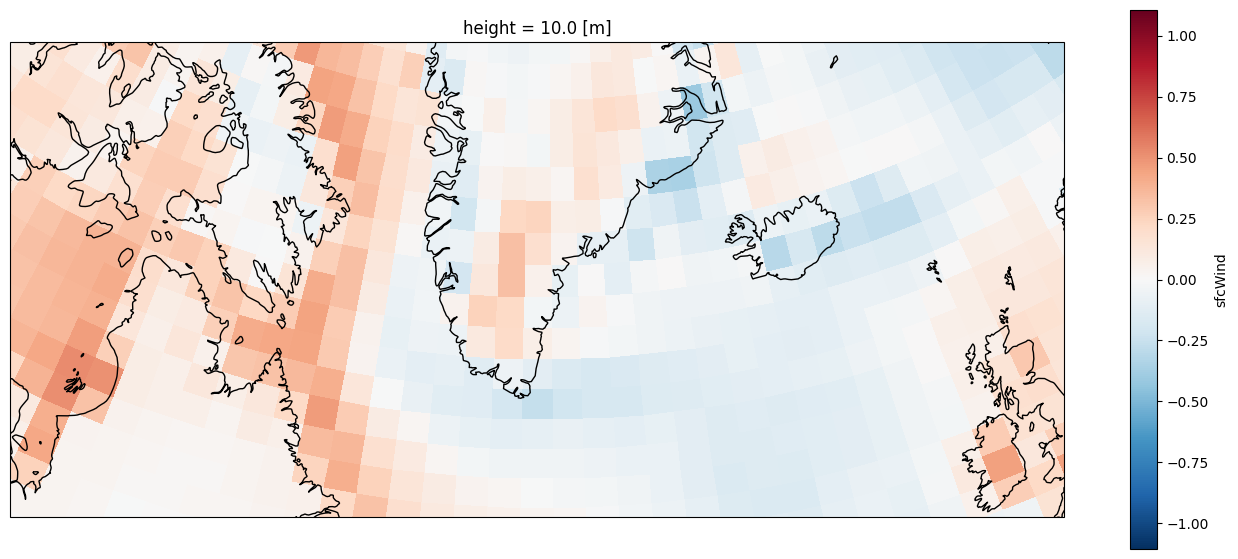

In [86]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
(mean_585-mean_126).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])
plt.show()


In [58]:
len(EnsTJ126.dic_TJ['r1i1p1f1'].events())/85


11.647058823529411

In [59]:
len(EnsTJ126.dic_TJ['r2i1p1f1'].events())/85

11.776470588235295

In [60]:
len(EnsTJ126.dic_TJ['r3i1p1f1'].events())/85

11.729411764705882

In [61]:
len(EnsTJ126.dic_TJ['r3i1p1f1'].events())/85

11.729411764705882

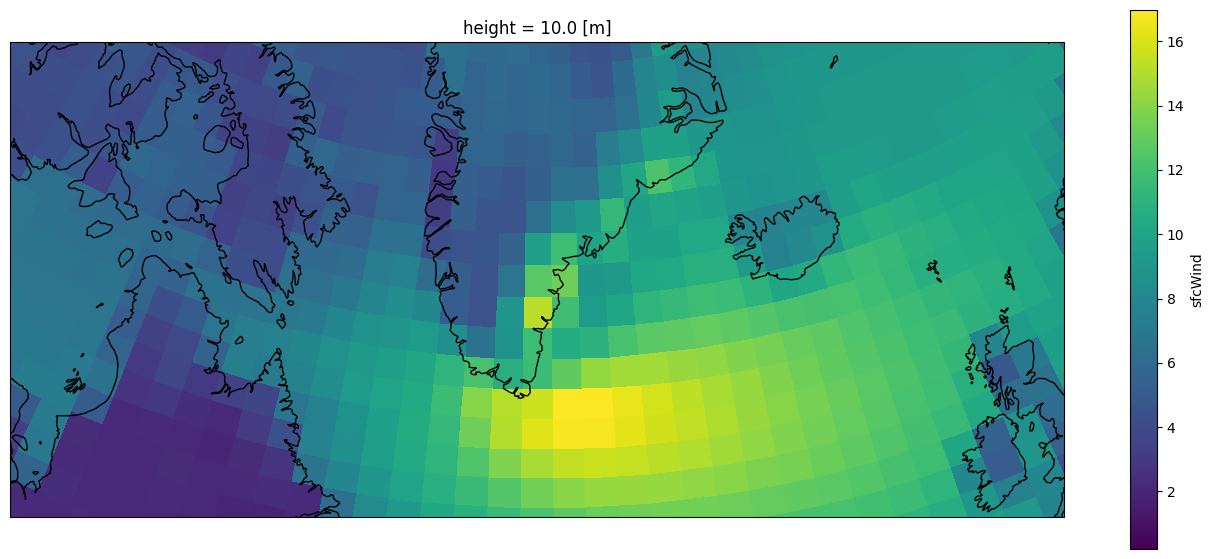

In [82]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
EnsTJ126.dic_TJ['r2i1p1f1'].windmag().plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])

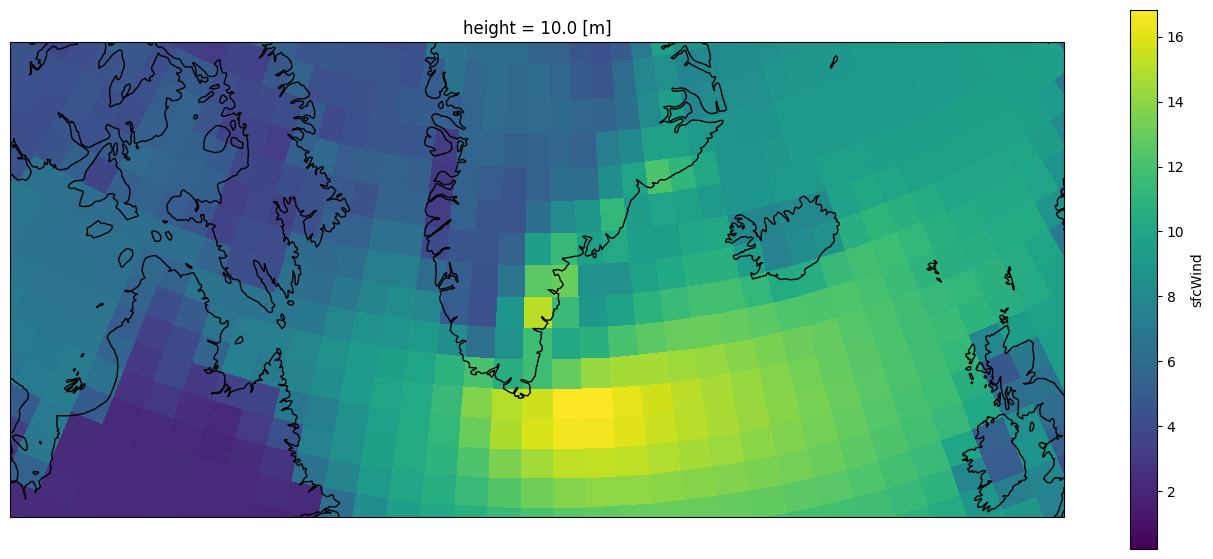

In [63]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
EnsTJ126.dic_TJ['r4i1p1f1'].windmag().plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])

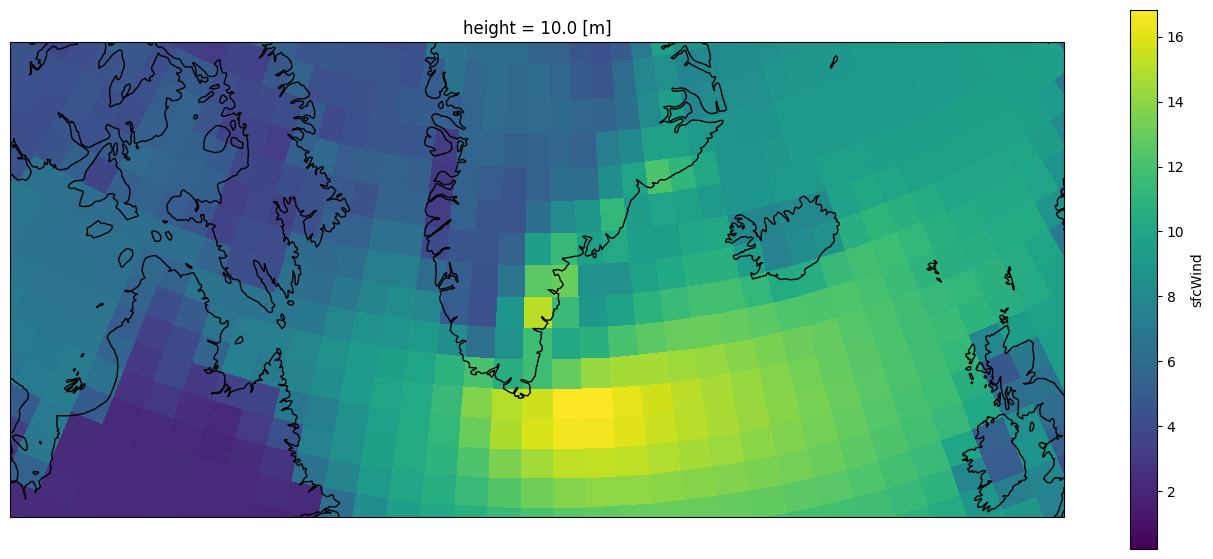

In [64]:
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
EnsTJ126.dic_TJ['r4i1p1f1'].windmag().plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 50, 70])

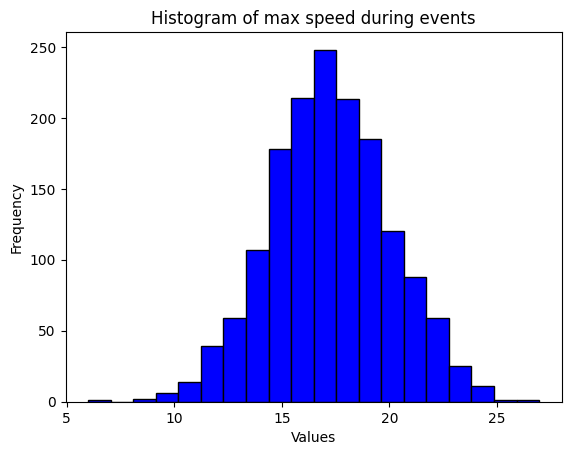

array([17.483723, 20.756104, 15.268032, ..., 15.405085, 18.462393,
       17.244886], dtype=float32)

In [65]:
EnsTJ126.dic_TJ['r1i1p1f1'].histo_vent()

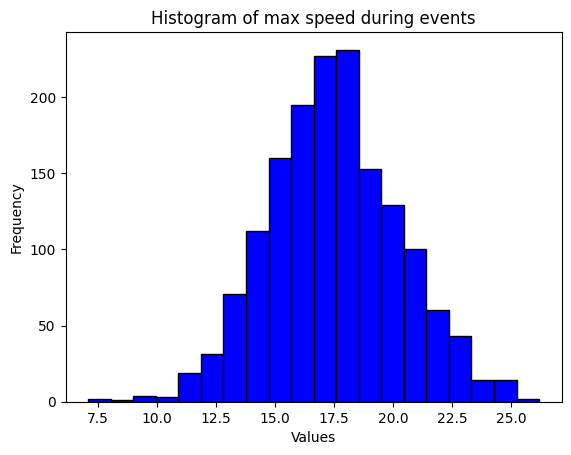

array([18.71036 , 17.265314, 19.199638, ..., 19.806477, 19.76859 ,
       16.721725], dtype=float32)

In [66]:
EnsTJ126.dic_TJ['r2i1p1f1'].histo_vent()

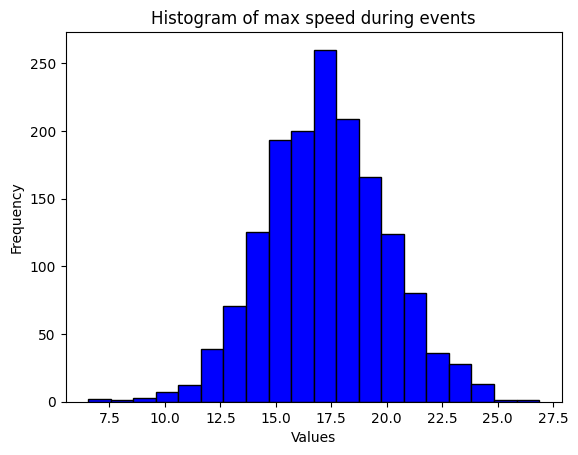

array([15.73377 , 16.588696,  7.360715, ..., 14.520745, 17.170895,
       17.33294 ], dtype=float32)

In [67]:
EnsTJ126.dic_TJ['r3i1p1f1'].histo_vent()

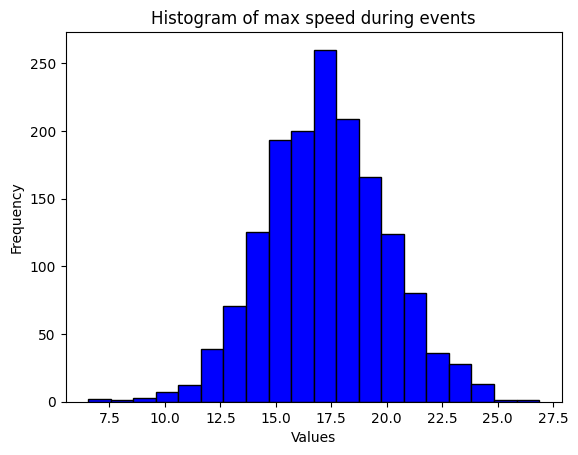

array([15.73377 , 16.588696,  7.360715, ..., 14.520745, 17.170895,
       17.33294 ], dtype=float32)

In [68]:
EnsTJ126.dic_TJ['r3i1p1f1'].histo_vent()

In [43]:
EnsTJ126.dic_TJ['r1i1p1f1'].components[0]

array([9.99920165e-01, 1.26357751e-02, 1.33308772e-07, 1.61662169e-07,
       1.64869587e-07])

In [44]:
EnsTJ126.dic_TJ['r2i1p1f1'].components[0]

array([ 9.99999769e-01, -6.80084831e-04,  1.34119566e-07,  1.61019338e-07,
        1.63585555e-07])

In [45]:
EnsTJ126.dic_TJ['r3i1p1f1'].components[0]

array([9.99974253e-01, 7.17595241e-03, 1.32979481e-07, 1.60387022e-07,
       1.64437711e-07])

In [46]:
EnsTJ126.dic_TJ['r4i1p1f1'].components[0]


array([9.99999833e-01, 5.78583781e-04, 1.35404739e-07, 1.61292088e-07,
       1.62956560e-07])

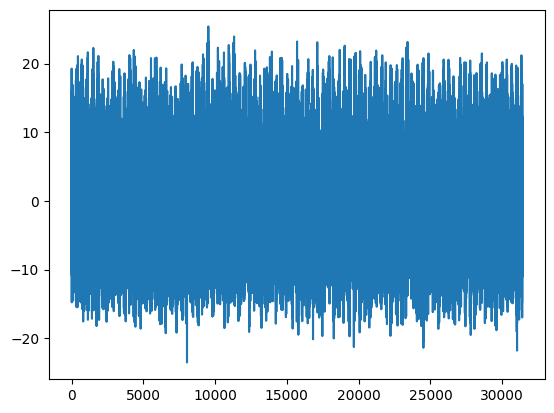

In [49]:
plt.plot(EnsTJ126.dic_TJ['r1i1p1f1'].Xpca[:,0])

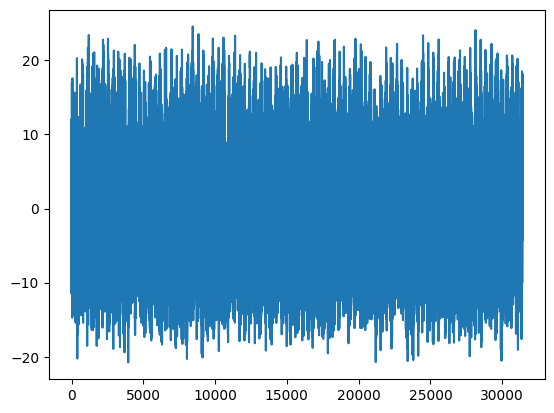

In [51]:
plt.plot(EnsTJ126.dic_TJ['r2i1p1f1'].Xpca[:,0])